In [1]:
import tarfile,sys
import pandas as pd
import os
import simplejson
import re as regex
import time
import json
from random import random
from textblob import TextBlob
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser as dateparser
from collections import Counter

In [2]:
parent_dir = 'shared_task_data/'
train_dir = 'final_training_data/'
test_dir = 'final_testing_data/'

In [19]:
def untar(fname, extract_path):
    if (fname.endswith("tar") or fname.endswith("tgz") ):
        tar = tarfile.open(fname)
        tar.extractall(extract_path)
        tar.close()
        print("Extracted " + str(fname) + " in Current Directory")
    else:
        print("Not a tar.gz file: '%s '" % sys.argv[0])

In [20]:
# untar parent directory, training and testing subdirectories
untar('shared_task_data.tar', parent_dir)

Extracted shared_task_data.tar in Current Directory


In [22]:
for i in range(1, 51): 
    fpath=parent_dir + train_dir + str(i) + '.tgz'
    untar(fpath, train_dir)
    
for i in range(60, 90): 
    fpath=parent_dir + test_dir + str(i) + '.tgz'
    untar(fpath, test_dir)

Extracted shared_task_data/final_training_data/1.tgz in Current Directory
Extracted shared_task_data/final_training_data/2.tgz in Current Directory
Extracted shared_task_data/final_training_data/3.tgz in Current Directory
Extracted shared_task_data/final_training_data/4.tgz in Current Directory
Extracted shared_task_data/final_training_data/5.tgz in Current Directory
Extracted shared_task_data/final_training_data/6.tgz in Current Directory
Extracted shared_task_data/final_training_data/7.tgz in Current Directory
Extracted shared_task_data/final_training_data/8.tgz in Current Directory
Extracted shared_task_data/final_training_data/9.tgz in Current Directory
Extracted shared_task_data/final_training_data/10.tgz in Current Directory
Extracted shared_task_data/final_training_data/11.tgz in Current Directory
Extracted shared_task_data/final_training_data/12.tgz in Current Directory
Extracted shared_task_data/final_training_data/13.tgz in Current Directory
Extracted shared_task_data/final_t

## Preprocessing

In [3]:
from sklearn import preprocessing as pp
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from tokenize import generate_tokens
import numpy as np
import re

def preprocess_tweet(tweet):
    stemmer = PorterStemmer()
    # convert all strings to lowercase
    tweet = tweet.lower()
    # remove all punctuations  
    tweet = re.sub('[^\w\s]', '', tweet)
    words = tweet.split()
    _words = [] # final word list

    for index, word in enumerate(words):
        # remove all stopwords
        if word not in stopwords.words('english'):
            # if not stopword, lemmatize 
            _words.append(stemmer.stem(word))

    tweet = ' '.join(_words)
    return tweet 

## Define Features

In [4]:
def insomnia_count(target, pos_count, neg_count):
    hour = target['created_at'].hour

    if hour > 9:
        neg_count += 1
    else:
        pos_count += 1
    return pos_count, neg_count


def avg_sentiment(statuses):
    avg = 0
    for status in statuses:
        blob = TextBlob(status)
        sentiment = blob.sentiment.polarity
        avg += sentiment
    avg_sentiment = avg / len(statuses)
    return avg_sentiment

def first_person(statuses):
    count = 0
    first_person = ["i", "id", "ill", "im", "ive", "me", "my"]
    for status in statuses:
        text = status.split()
        for word in first_person:
            count += text.count(word)   
    return count / len(statuses)

def tsugawa_terms(statuses):
    tsugawa_terms = ["even if", "low fever", "very", "workplace", "hopeless", "disappear", "too much", "sickness", "bad", "hospital"]
    count = 0
    count_per_tweet = 0
    for status in statuses:
        for term in tsugawa_terms:
            count += status.count(term)
    return count / len(statuses)

def retweet_count(target, retweet_count):
    retweet_count += int(target['retweet_count'])
    return retweet_count

def url_count(target, url_count):
    url_count += len(target['entities']['urls'])
    return url_count

def num_word_char(statuses):
    num_char = 0
    num_words = 0
    for status in statuses:
        num_words += len(status.split())
        num_char += len(status)
    
    num_words = num_words / len(statuses)
    num_char = num_char / len(statuses)
    return num_words, num_char

def usertags(target, usertags, set_usertags):
    user_mentions = target['entities']['user_mentions']
    for user in user_mentions:
        set_usertags.add(user['screen_name'])

    usertags += len(user_mentions)
    return usertags, set_usertags

## Read User Tweets

In [5]:
# read user csv file
userInfo = pd.read_csv('anonymized_user_info_by_chunk.csv')
user_condition = {}
for index, row in userInfo.iterrows():
    userName = row['anonymized_screen_name']
    condition = row['condition'] 
    if condition == 'depression':
        user_condition[userName] = 1
    elif condition == 'control':
        user_condition[userName] = 0

In [6]:
columns = ['user', 'depression', 'avg_sentiment', 'tsugawa_terms', 'first_person','avg_word_length','avg_char_length', 'insomnia_index', 'retweet_rate', 'url_percent', 'avg_usertags', 'avg_unique_usertags']
train_data=pd.DataFrame(columns=columns)
test_data=pd.DataFrame(columns=columns)

#read user tweets
for user, condition in user_condition.items():
    test = False
    tweet_train_file = train_dir + user + '.tweets'
    tweet_test_file = test_dir + user + '.tweets'
    if os.path.isfile(tweet_train_file):
        tweet_file = tweet_train_file 
    elif os.path.isfile(tweet_test_file):
        tweet_file = tweet_test_file
        test = True
    else:
        print('no tweets found for user')
        continue
    
    try:  
        print('Reading file '+ tweet_file)
        tweets = pd.read_json(tweet_file, lines=True)
        tweets['user'] = user
        tweets['depression'] = condition
        # get list of tweets for each user
        tweet_texts = []
        insomnia_pos_count = 0
        insomnia_neg_count = 0
        num_retweets = 0
        num_urls = 0
        num_usertags = 0
        set_usertags = set()
        
        for i in range(len(tweets)):
            tweet = tweets.iloc[i]
            # preprocess tweet texts per user 
            processed_tweet = preprocess_tweet(tweet['text'])
            tweet_texts.append(processed_tweet)
            num_retweets = retweet_count(tweet, num_retweets)
            num_urls = url_count(tweet, num_urls)
            num_usertags, set_usertags = usertags(tweet, num_usertags, set_usertags)
            insomnia_pos_count, insomnia_neg_count = insomnia_count(tweet, insomnia_pos_count, insomnia_neg_count)
            
        tweets['insomnia_index'] = (insomnia_neg_count - insomnia_pos_count) / len(tweets)
        tweets['retweet_rate'] = num_retweets / len(tweets)
        tweets['url_percent'] = num_urls / len(tweets)
        tweets['avg_usertags'] = num_usertags / len(tweets)
        tweets['avg_unique_usertags'] = len(set_usertags) / len(tweets)
        tweets['first_person'] = first_person(tweet_texts)
        tweets['avg_sentiment'] = avg_sentiment(tweet_texts)
        tweets['tsugawa_terms'] = tsugawa_terms(tweet_texts)
        word_char_lengths = num_word_char(tweet_texts)
        tweets['avg_word_length'] = word_char_lengths[0]
        tweets['avg_char_length'] = word_char_lengths[1]
        
        user_row = tweets[columns].loc[0:0]
        if test == True:
            test_data = test_data.append(user_row)
        else:
            train_data = train_data.append(user_row)
    except:
        print("Error parsing tweet!")

no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_training_data/p1oWIeRy95.tweets
Reading file final_training_data/u6Q1cPYaegBS.tweets
Reading file final_training_data/q5nbV1Dwkx3Uz8y.tweets
Error parsing tweet!
Reading file final_training_data/cpZb1zL.tweets
Reading file final_training_data/nC8trwq.tweet

Reading file final_training_data/fS_NsCmikG.tweets
Reading file final_training_data/r_AL08Us8KD.tweets
Reading file final_training_data/epbVjo65LYSb.tweets
Reading file final_training_data/fjLCf4wIe1Yts.tweets
Reading file final_training_data/hMuEjR7TAHw.tweets
Reading file final_training_data/l02NBMxaBtp.tweets
Reading file final_training_data/xR7COyw1hCgMdJ.tweets
Reading file final_training_data/fPnJmwvigb4NDB.tweets
Error parsing tweet!
Reading file final_training_data/c6RBMyzEGz.tweets
Reading file final_training_data/lNkP1wbG_.tweets
Reading file final_training_data/tYbkBjKn_HhbKA.tweets
Reading file final_training_data/tFm_Zt17.tweets
Reading file final_training_data/hWx1ZCISapk.tweets
Reading file final_training_data/f1gToeZMsown.tweets
Reading file final_training_data/lvXWGVOeVbaO.tweets
Error parsing tweet!
Reading file final_training_data/ndt26Jc2.tweets
Reading file final_training_data/tjUQM0XFoFd6.tweets
Reading file final_training_data/pKiT8RjFUoFNN.tweets
Reading file fi

Reading file final_training_data/d5W9F315ClWuT.tweets
Reading file final_training_data/xbm01RF4kr.tweets
Reading file final_training_data/u9k5tz3yeg38Z.tweets
Reading file final_training_data/quD3WcPmeNf9Ver.tweets
Reading file final_training_data/b7JDj_Sb.tweets
Reading file final_training_data/mrBNd41K.tweets
Reading file final_training_data/mFt6W0RyBGub.tweets
Reading file final_training_data/q0W_J_Ee.tweets
Reading file final_training_data/fPh49Tvz_Cu0y0R.tweets
Reading file final_training_data/vmXfij.tweets
Reading file final_training_data/pFRUDVnfMvng.tweets
Reading file final_training_data/ijinLoqohOP.tweets
Error parsing tweet!
Reading file final_training_data/oFnukUt21FYo.tweets
Reading file final_training_data/w9rpyg0EUSU03g.tweets
Reading file final_training_data/no6eldDW_U0Pq_.tweets
Reading file final_training_data/zvnSahMKTd.tweets
Reading file final_training_data/eTB92A2U3X5.tweets
Reading file final_training_data/wi3bUI3nYk_Pd.tweets
Reading file final_training_data/wWd

Reading file final_training_data/fdvbKeh4NIZ.tweets
Reading file final_training_data/hANUdm_kJzGbnl.tweets
Reading file final_training_data/uiHBxWiuleJL.tweets
Reading file final_training_data/bBj3tEy.tweets
Reading file final_training_data/sY0azlpwRe.tweets
Reading file final_training_data/xosKMdKMJ.tweets
Reading file final_training_data/cmvxX_NWJd5DL.tweets
Reading file final_training_data/gAxzxIWjvahh.tweets
Reading file final_training_data/xnozWTA40p.tweets
Reading file final_training_data/fvFcDA0P8oJ_6.tweets
Reading file final_training_data/dJJPhbPju.tweets
Reading file final_training_data/p2HB96F23s.tweets
Error parsing tweet!
Reading file final_training_data/rPubIuIf.tweets
Reading file final_training_data/guU7PUipk5n4.tweets
Reading file final_training_data/f2fooSn.tweets
Reading file final_training_data/cS8tppTDL3.tweets
Reading file final_training_data/bi0xOvA88H1OT.tweets
Error parsing tweet!
Reading file final_training_data/j11yDOcjhW.tweets
Reading file final_training_da

Reading file final_training_data/tkkzidBh9ZWsG.tweets
Error parsing tweet!
Reading file final_training_data/u4Nz74q5SCdyObn.tweets
Reading file final_training_data/k6aDpyIS0.tweets
Reading file final_training_data/t91wktiYrsF.tweets
Reading file final_training_data/e3OjnFN0VbsoV.tweets
Reading file final_training_data/ms_0SI9_YGA2B.tweets
Reading file final_training_data/qodUBoXFyHq6T03.tweets
Error parsing tweet!
Reading file final_training_data/snMj6XzZvN.tweets
Reading file final_training_data/k7F4IlnB5.tweets
Reading file final_training_data/oxkZfV_7pE.tweets
Reading file final_training_data/oetczv3_S3oPac.tweets
Error parsing tweet!
Reading file final_training_data/dadlS4XUHbvfHi.tweets
Error parsing tweet!
Reading file final_training_data/fNlTErjbA.tweets
Reading file final_training_data/ukNquMkP3W1.tweets
Reading file final_training_data/L844xvCOIjDJ3ot.tweets
Reading file final_training_data/n4BOlCvNErp75.tweets
Reading file final_training_data/dVulYpSpRz.tweets
Reading file fi

Reading file final_training_data/f8D2Tt5ySDU.tweets
Reading file final_training_data/pYZlibq.tweets
Reading file final_training_data/iTe8_RfG8.tweets
Reading file final_training_data/gxssg5e.tweets
Reading file final_training_data/b90Xd3CWW.tweets
Reading file final_training_data/c5egAWoKy8.tweets
Reading file final_training_data/jGC0j9ijNBn1.tweets
Reading file final_training_data/fONxVasny2.tweets
Reading file final_training_data/wmwQ6RjBaiq.tweets
Reading file final_training_data/nVHGUx.tweets
Reading file final_training_data/sObIxboD1JgpBHe.tweets
Reading file final_training_data/n8bDYXAG5S85.tweets
Reading file final_training_data/vpcHddZiD.tweets
Reading file final_training_data/mOanz1kg6b0oSxG.tweets
Reading file final_training_data/QIbT5IkcWpj.tweets
Reading file final_training_data/c1IQ5GCb_99LSxX.tweets
Error parsing tweet!
Reading file final_training_data/id4O8tg.tweets
Reading file final_training_data/sZVVktDN8qqjA.tweets
Reading file final_training_data/hbwm5Tyt801.tweets


no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/sgh85pBVTrOI5.tweets
Error parsing tweet!
Reading file final_testing_data/j15O_iq22wviI.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/LSdFmgw.tweets
Reading file final_testing_data/OHrn8EBpdMbPc.tweets
Error parsing tweet!
Reading file final_testing_data/oJBU65HkIKJ.tweets
Error parsing tweet!
Reading file final_testing_data/qUi02Rtnn9.tweets
Reading file final_testing_data/qz15FDkWR.tweets
Reading file final_testing_data/qdUlpt7G_xuDJ.tweets
Reading file final_testing_data/5trLyO.tweets
Reading file final_testing_data/xamatEwJzmBM.tweets
Reading file final_testing_data/dztLiT.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/pjmeJFCj9.tweets
Reading file final_testing_data/pLwkcIQ1KPKKNLE.tweets
Error parsing tweet!
Reading f

Reading file final_testing_data/vw1G3Kfi1K.tweets
Reading file final_testing_data/ede9eCGcC.tweets
Reading file final_testing_data/ngEVlO5dC.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/uAYNfjer5H4.tweets
Error parsing tweet!
Reading file final_testing_data/ohKTsoykPhh8ZuS.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/hOnaPe9X9ZuuoN.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/cJJldnDL5oP_QD.tweets
Error parsing tweet!
Reading file final_testing_data/dl7Vaigu.tweets
Reading file final_testing_data/ubNzj1B.tweets
Error parsing tweet!
Reading file final_testing_data/ngl7M2ou5B.tweets
Reading file final_testing_data/uwcXjnBq.tweets
Reading file final_testing_data/sopdPKAFkw3QerH.tweets
Reading file final_testing_data/u_P3xdlRS8naqbi.tweets
Reading file final_tes

no tweets found for user
no tweets found for user
Reading file final_testing_data/lYU6yETIaN3H.tweets
Reading file final_testing_data/cEkZxh6OEtC2.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/nYpuu7dWvXMFUG9.tweets
Reading file final_testing_data/rSaU1hkUY.tweets
no tweets found for user
no tweets found for user
Reading file final_testing_data/puTtjUFpRciDHX.tweets
Reading file final_testing_data/gGRekzUp_6oLZ2P.tweets
Reading file final_testing_data/ljsDD9z1vYpW.tweets
no tweets found for user
Reading file final_testing_data/dn8Oyr4n.tweets
Reading file final_testing_data/vcR68dcu1de.tweets
Reading file final_testing_data/h8z2xMU8q7mMWY.tweets
Reading file final_testing_data/v8tLj9e.tweets
Reading file final_testing_data/q5tE5dA6xiDnQ.tweets
Error parsing tweet!
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/wo5BVq1NFaqo08.tweets
Reading file final_testing_data/p43muIH.tweets
Readin

Reading file final_testing_data/uF76QlQxlcOYn.tweets
Reading file final_testing_data/d8sMxxX8uhYioVo.tweets
Reading file final_testing_data/vvyhD9dsqxT.tweets
Reading file final_testing_data/bjc2Kgay.tweets
Reading file final_testing_data/f2gRmoHUul.tweets
Reading file final_testing_data/le__3ezwpf.tweets
Reading file final_testing_data/fyl6PKTMEeaweMw.tweets
Error parsing tweet!
Reading file final_testing_data/jKXYTGn9CNGOtK.tweets
no tweets found for user
no tweets found for user
no tweets found for user
no tweets found for user
Reading file final_testing_data/ll_gyBvD2vo9A.tweets
Reading file final_testing_data/eVVQgZHpk9.tweets
Reading file final_testing_data/xMZSqgcL0pH.tweets
Error parsing tweet!
Reading file final_testing_data/si_wpIUDCDtRMtp.tweets
Reading file final_testing_data/iuqR1sQB9srL.tweets
no tweets found for user
Reading file final_testing_data/lCwkSx2Fau.tweets
Reading file final_testing_data/sqOFbJ0CQYM.tweets
Reading file final_testing_data/wuwHUfST.tweets
no twee

In [7]:
# save user data and features to file
test_data.to_csv('test.csv', encoding='utf-8')
train_data.to_csv('train.csv', encoding='utf-8')

In [8]:
# read user data from file
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')

In [15]:
train_data

,Unnamed: 0,user,depression,avg_sentiment,tsugawa_terms,first_person,avg_word_length,avg_char_length,insomnia_index,retweet_rate,url_percent,avg_usertags,avg_unique_usertags
0,0,p1oWIeRy95,1,0.345387,0.013000,0.076000,6.507333,41.883667,0.240667,531.117000,0.074000,0.669667,0.099667
1,0,u6Q1cPYaegBS,0,0.102646,0.035433,0.068241,7.842520,48.314961,0.301837,127.213911,0.018373,0.791339,0.124672
2,0,cpZb1zL,0,0.044621,0.056235,0.080685,8.418093,55.464548,0.007335,112.332518,0.405868,0.584352,0.305623
3,0,nC8trwq,1,0.060528,0.042333,0.175000,6.342000,39.527333,0.505333,468.096333,0.007333,0.776667,0.118000
4,0,mbKpnEfzJFe,0,0.080818,0.037333,0.113333,6.004333,38.408333,-0.305333,147.364333,0.021667,0.576667,0.117667
5,0,cMwx3Gi9RuskPTa,0,0.053345,0.032604,0.147182,6.768048,43.253377,0.686074,21.761993,0.018165,0.763857,0.238007
6,0,gnau5VYmZon,1,0.117132,0.015000,0.052000,7.946000,55.501000,0.268667,10.998333,0.259333,0.848000,0.297333
7,0,w5zZbsisYcaA,0,0.186145,0.006289,0.008386,8.642558,66.757862,0.291405,24.219078,0.766247,0.230608,0.174004
8,0,q69HY7gQXtabz,0,0.096592,0.026000,0.066000,9.527667,68.834000,0.082667,5.197333,0.425333,1.164333,0.383667
9,0,ee7ABQXno,0,0.168221,0.016333,0.111000,5.629333,35.589333,0.194667,28.748667,0.064667,0.801000,0.090333


## Create Feature Matrix

In [12]:
import numpy as np

def create_feature_matrix(data):
    feature_matrix = []
    for i in range(len(data)):
        user_features = np.array(data.iloc[i,2:], dtype = np.float32)
        feature_matrix.append(user_features)
    return feature_matrix

train_feature_matrix = np.array(create_feature_matrix(train_data))
test_feature_matrix = np.array(create_feature_matrix(test_data))

print(len(train_feature_matrix))
print(len(test_feature_matrix))

794
395


In [13]:
X_train = train_feature_matrix[:,1:]
y_train = train_feature_matrix[:,0]
X_test = train_feature_matrix[:,1:]
y_test = train_feature_matrix[:,0]

In [14]:
(X_train, y_train)

(array([[0.34538692, 0.013     , 0.076     , ..., 0.074     , 0.66966665,
         0.09966667],
        [0.10264627, 0.03543307, 0.06824147, ..., 0.0183727 , 0.79133856,
         0.12467191],
        [0.04462111, 0.05623472, 0.08068459, ..., 0.40586796, 0.5843521 ,
         0.30562347],
        ...,
        [0.0028801 , 0.02533333, 0.164     , ..., 0.025     , 0.5693333 ,
         0.00833333],
        [0.05157632, 0.02966667, 0.09733333, ..., 0.06233333, 0.8946667 ,
         0.158     ],
        [0.08875076, 0.01133333, 0.05866667, ..., 0.14033334, 1.654     ,
         0.22766666]], dtype=float32),
 array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0.

In [20]:
# apply naive bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools

clf = GaussianNB()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
pred = clf.predict(X_test)

# Compute confusion matrix
cm_NB = confusion_matrix(y_test, pred)
print(score, cm_NB)

0.6372795969773299 [[334 179]
 [109 172]]


In [21]:
# apply SVM model
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
pred = clf.predict(X_test)

# Compute confusion matrix
cm_SVM = confusion_matrix(y_test, pred)
print(score, cm_SVM)

0.8816120906801007 [[509   4]
 [ 90 191]]


In [22]:
# apply KNN model
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)
score = neigh.score(X_test, y_test)
pred = neigh.predict(X_test)

# Compute confusion matrix
cm_KNN = confusion_matrix(y_test, pred)
print(score, cm_KNN)

0.6926952141057935 [[457  56]
 [188  93]]


In [24]:
# apply random forest model
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=10)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
pred = clf.predict(X_test)

# Compute confusion matrix
cm_RF = confusion_matrix(y_test, pred)
print(score, cm_RF)

0.9836272040302267 [[512   1]
 [ 12 269]]


In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.65107212 0.34892788]
 [0.38790036 0.61209964]]
Normalized confusion matrix
[[0.99220273 0.00779727]
 [0.3202847  0.6797153 ]]
Normalized confusion matrix
[[0.89083821 0.10916179]
 [0.66903915 0.33096085]]
Normalized confusion matrix
[[0.99805068 0.00194932]
 [0.04270463 0.95729537]]


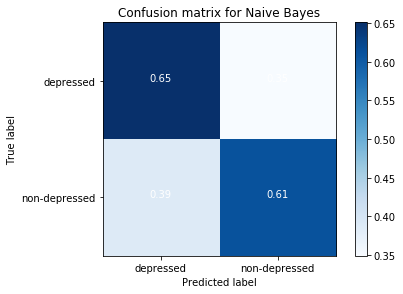

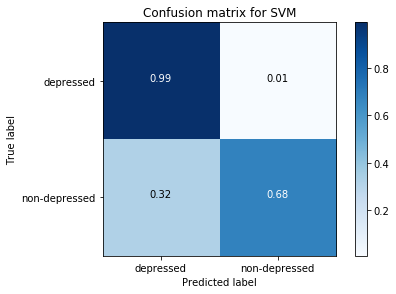

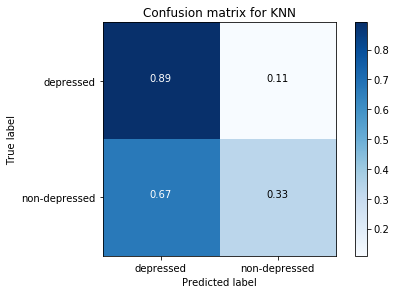

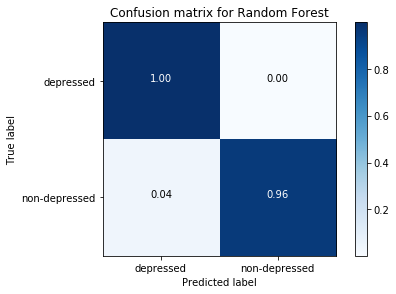

In [25]:
class_names = ['depressed', 'non-depressed']

# Plot confusion matrix for Naive Bayes
plt.figure()
plot_confusion_matrix(cm_NB, classes=class_names, normalize=True, 
                      title='Confusion matrix for Naive Bayes')

# Plot confusion matrix for SVM
plt.figure()
plot_confusion_matrix(cm_SVM, classes=class_names, normalize=True,
                      title='Confusion matrix for SVM')

# Plot confusion matrix for KNN
plt.figure()
plot_confusion_matrix(cm_KNN, classes=class_names, normalize=True,
                      title='Confusion matrix for KNN')

# Plot confusion matrix for RF
plt.figure()
plot_confusion_matrix(cm_RF, classes=class_names, normalize=True,
                      title='Confusion matrix for Random Forest')

plt.show()